In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from sklearn.metrics import (accuracy_score, classification_report, 
                           roc_auc_score, confusion_matrix, RocCurveDisplay)

In [3]:
df = pd.read_excel('../Data/Processed/processed_info.xlsx')

# Сразу удалим CC50 и IC50, mM, так как они рассчитываются друг через друга.
df.drop(['CC50, mM', 'IC50, mM'], axis=1, inplace=True)

## Бинаризация меток класса

In [4]:
si_8 = 8
df['target'] = df['SI'].apply(lambda x: 1 if x > si_8 else 0)
df.drop(['SI'], axis=1, inplace=True)

## Логистическая регрессия

Accuracy: 0.6716417910447762

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76       130
           1       0.55      0.42      0.48        71

    accuracy                           0.67       201
   macro avg       0.63      0.62      0.62       201
weighted avg       0.66      0.67      0.66       201

ROC-AUC: 0.6890574214517876


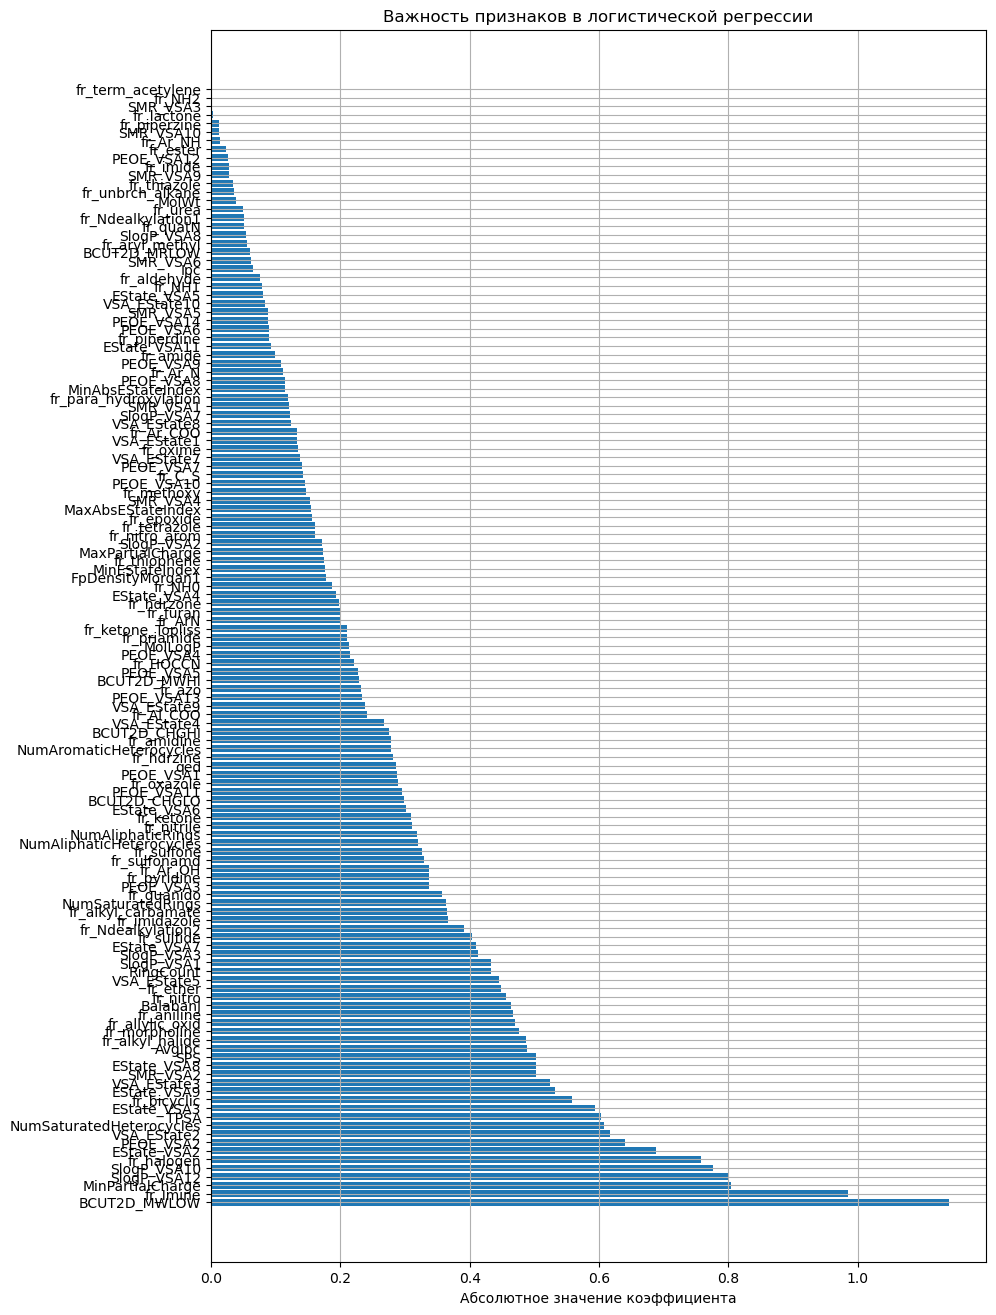

In [5]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Вероятности для ROC-AUC

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

# Важность признаков (коэффициенты)
if hasattr(model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0],
        'Abs_Coefficient': np.abs(model.coef_[0])  # Абсолютные значения для сравнения
    }).sort_values('Abs_Coefficient', ascending=False)

# Визуализация
plt.figure(figsize=(10, 16))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'])
plt.title('Важность признаков в логистической регрессии')
plt.xlabel('Абсолютное значение коэффициента')
plt.grid(True)
plt.show()

## Дерево решений

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Accuracy: 0.6865671641791045

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78       130
           1       0.59      0.38      0.46        71

    accuracy                           0.69       201
   macro avg       0.65      0.62      0.62       201
weighted avg       0.67      0.69      0.67       201

ROC-AUC: 0.6716143011917659

Confusion Matrix:
 [[111  19]
 [ 44  27]]


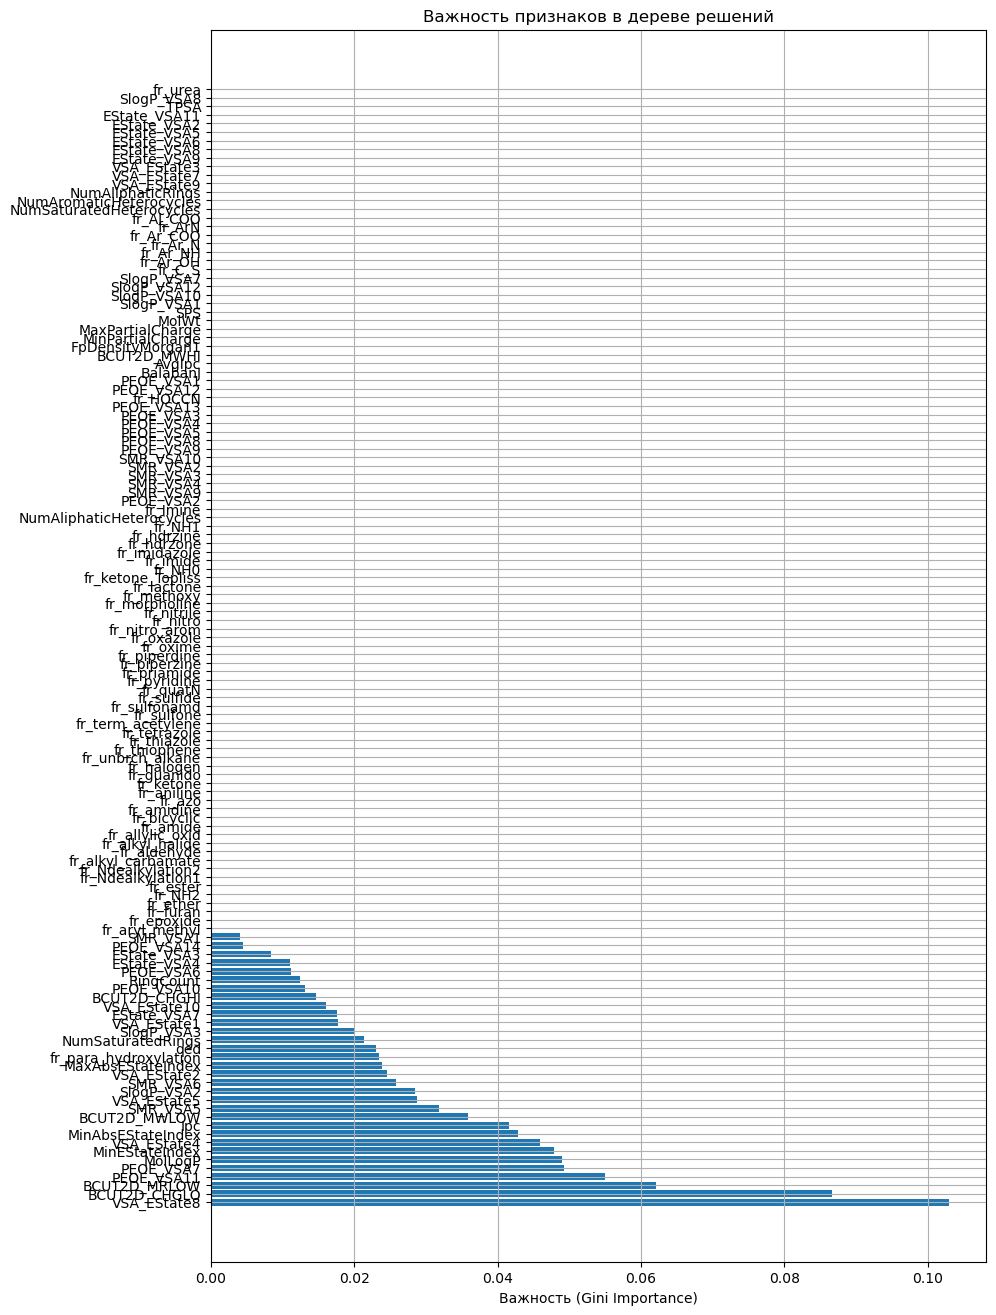


Дерево слишком глубокое для визуализации (глубина = 7).


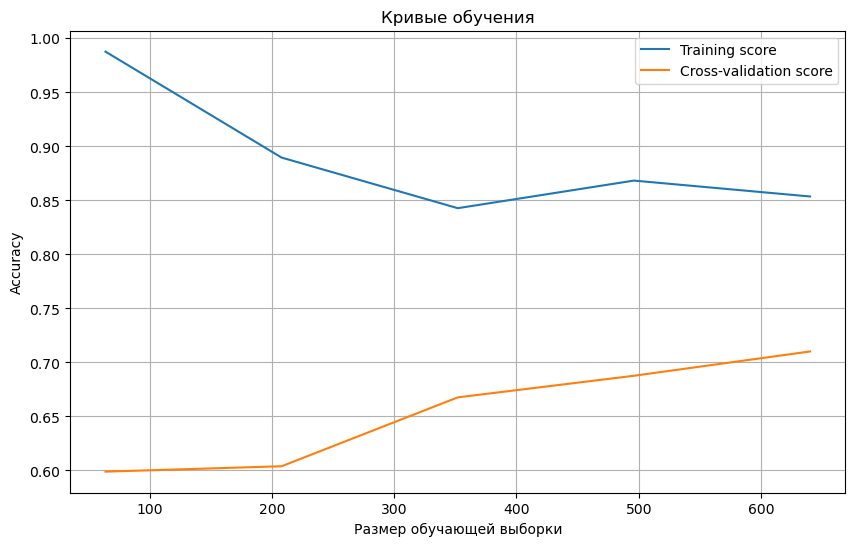

In [6]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Подбор гиперпараметров через GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, None],           # Глубина дерева
    'min_samples_split': [2, 5, 10],            # Минимальное число образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],              # Минимальное число образцов в листе
    'criterion': ['gini', 'entropy'],           # Критерий разделения
    'max_features': ['sqrt', 'log2', None]      # Количество признаков для поиска лучшего разделения
}

model = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,                # Количество фолдов кросс-валидации
    scoring='accuracy',  # Метрика для оптимизации
    n_jobs=-1            # Использовать все ядра процессора
)
model.fit(X_train_scaled, y_train)

print("Лучшие параметры:", model.best_params_)
best_model = model.best_estimator_

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 16))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важность признаков в дереве решений')
plt.xlabel('Важность (Gini Importance)')
plt.grid(True)
plt.show()

# Визуализация лучшего дерева (для max_depth <= 3)
if best_model.get_depth() <= 3:
    plt.figure(figsize=(20, 10))
    plot_tree(
        best_model,
        feature_names=X.columns,
        class_names=['IC50 ≤ медианы', 'IC50 > медианы'],
        filled=True,
        rounded=True
    )
    plt.title("Оптимальное дерево решений")
    plt.show()
else:
    print("\nДерево слишком глубокое для визуализации (глубина = {}).".format(best_model.get_depth()))

# Кривые обучения
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Кривые обучения')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Случайный лес

Accuracy: 0.7014925373134329

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79       130
           1       0.63      0.37      0.46        71

    accuracy                           0.70       201
   macro avg       0.68      0.63      0.63       201
weighted avg       0.69      0.70      0.68       201

ROC-AUC: 0.7088840736728061

Confusion Matrix:
 [[115  15]
 [ 45  26]]

Feature Importance:
                Feature  Importance
63         VSA_EState8    0.026316
12        BCUT2D_CHGLO    0.026047
10        BCUT2D_MWLOW    0.025310
60         VSA_EState4    0.024808
3                  qed    0.022770
..                 ...         ...
123       fr_sulfonamd    0.000063
126       fr_tetrazole    0.000060
74           fr_Ar_COO    0.000031
125  fr_term_acetylene    0.000000
102         fr_hdrzine    0.000000

[131 rows x 2 columns]


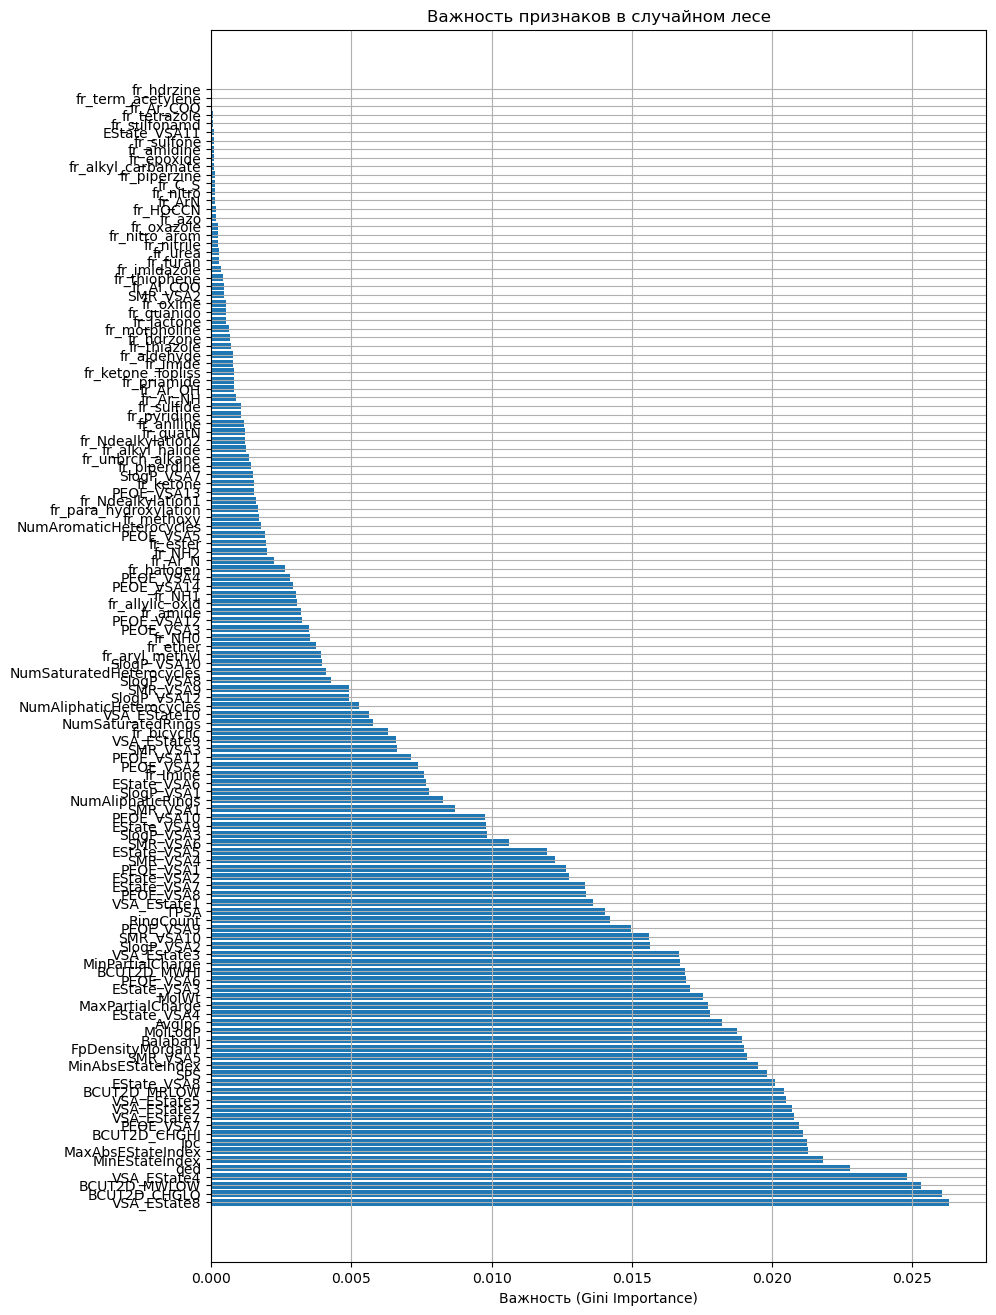

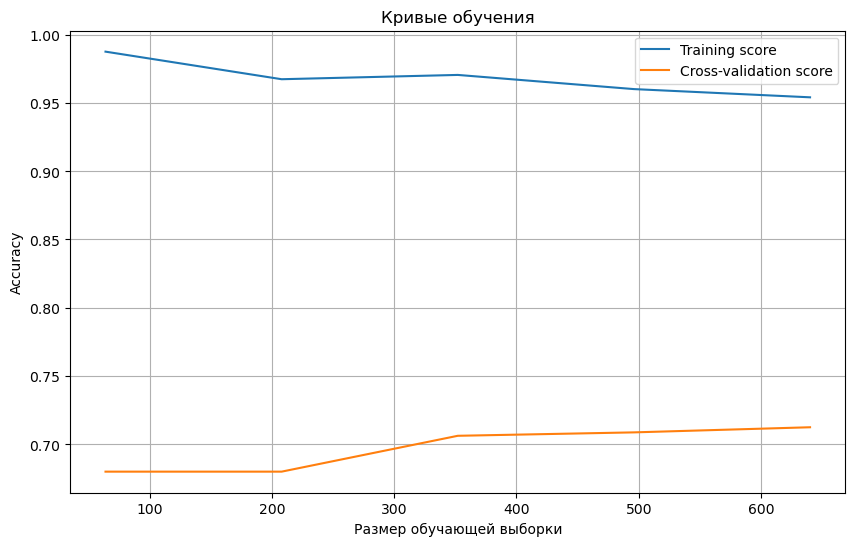

In [10]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(
    n_estimators=100,      # Количество деревьев
    max_depth=None,        # Глубина деревьев (None - до полного разделения)
    min_samples_split=2,   # Минимальное число образцов для разделения узла
    random_state=42,
    n_jobs=-1              # Использовать все ядра процессора
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Вероятности класса 1

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)

plt.figure(figsize=(10, 16))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важность признаков в случайном лесе')
plt.xlabel('Важность (Gini Importance)')
plt.grid(True)
plt.show()

# Кривые обучения
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Кривые обучения')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Метод ближайших соседей

Лучшие параметры: {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}

Accuracy: 0.7014925373134329

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.90      0.80       130
           1       0.65      0.34      0.44        71

    accuracy                           0.70       201
   macro avg       0.68      0.62      0.62       201
weighted avg       0.69      0.70      0.67       201

ROC-AUC: 0.697887323943662

Confusion Matrix:
 [[117  13]
 [ 47  24]]


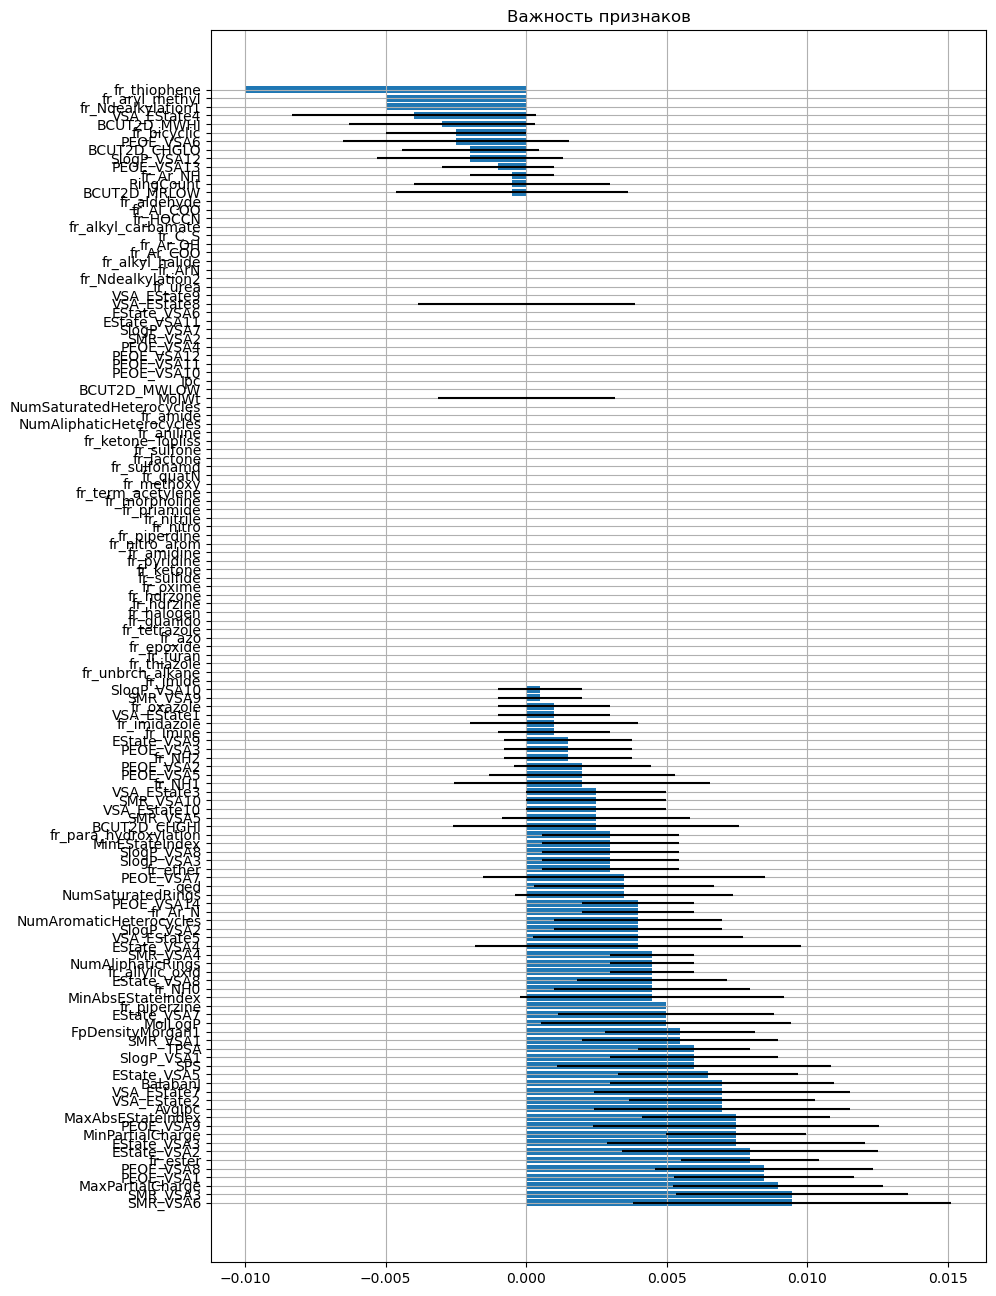

In [9]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_neighbors': range(3, 15),                # Число соседей (от 3 до 14)
    'weights': ['uniform', 'distance'],         # Веса: одинаковые или обратно пропорциональные расстоянию
    'p': [1, 2]                                 # Метрика (1 - манхэттенское, 2 - евклидово расстояние)
}

model = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,               # Кросс-валидация на 5 фолдов
    scoring='accuracy',
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

print("Лучшие параметры:", model.best_params_)
best_knn = model.best_estimator_

y_pred = best_knn.predict(X_test_scaled)
y_pred_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Анализ важности признаков
result = permutation_importance(
    best_knn, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10, 16))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], xerr=feature_importance['Std'])
plt.title('Важность признаков')
plt.grid(True)
plt.show()

## **Общий анализ результатов**

Все модели демонстрируют **схожий уровень точности (Accuracy 0.67-0.70)**, что указывает на:
- **Умеренную сложность задачи** (модели незначительно превосходят базовый уровень)
- **Явный дисбаланс в качестве предсказаний** между классами (лучшие показатели для класса 0)
- **Наличие потенциала для улучшения**, особенно для класса 1

### **Логистическая регрессия**
- **Accuracy**: 0.672
- **ROC-AUC**: 0.689 (2-е место)
- **Сильные стороны**:
  - Наиболее сбалансированный ROC-AUC
  - Лучшая precision для класса 1 (0.55)
- **Слабые стороны**:
  - Низкий recall для класса 1 (0.42)

### **Дерево решений**
- **Accuracy**: 0.687
- **ROC-AUC**: 0.672 (наихудший)
- **Сильные стороны**:
  - Лучший recall для класса 0 (0.85)
  - Простота интерпретации
- **Слабые стороны**:
  - Плохая работа с классом 1 (recall=0.38)

### **Случайный лес**
- **Accuracy**: 0.701 (максимальный)
- **ROC-AUC**: 0.709 (лидер)
- **Сильные стороны**:
  - Наивысшие Accuracy и ROC-AUC
  - Лучшая обобщающая способность
- **Слабые стороны**:
  - Значительный дисбаланс в recall (0.88 vs 0.37)

### **Метод ближайших соседей**
- **Accuracy**: 0.701 (совпадает со случайным лесом)
- **ROC-AUC**: 0.698
- **Сильные стороны**:
  - Сопоставимая с лесом точность
- **Слабые стороны**:
  - Наихудший recall для класса 1 (0.34)

## **Ключевые проблемы**

1. **Дисбаланс классов** (130 vs 71):
   - Все модели хуже предсказывают класс 1
   - Особенно страдает recall (меньше 0.42 у всех моделей)

2. **Компромисс между точностью и полнотой**:
   - Улучшение recall для класса 1 ведет к ухудшению precision

3. **Ограниченная предсказательная сила**:
   - ROC-AUC < 0.71 указывает на умеренное качество моделей


## **Рекомендации по улучшению**
1. **Балансировка классов**

2. **Подбор порога классификации**:
   - Оптимизировать не Accuracy, а F1-score или бизнес-метрики


### **Работа с признаками**
- Добавление полиномиальных признаков
- Взаимодействия между важными переменными